# CAPSTONE PROJECT - Online Retail Store Sales

## 1. Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

## 2. Import Packages

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install jinja2
!pip install mlxtend

In [2]:
# dont erase this!
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

C:\Users\fathu\AppData\Local\Temp\ipykernel_10200\2720934004.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import sqlite3
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, ticker as mtick, dates as mdates, ticker as ticker
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

warnings.simplefilter(action='ignore')

class CONFIG:
    DB_PATH = './retail_online_shop.db'
    CSV_PATH = './data'

In [4]:
# create data folder
!mkdir data

A subdirectory or file data already exists.


## 3. Connect SQLite to Python

In [5]:
# connect to sqlite locally
conn = sqlite3.connect(CONFIG.DB_PATH)
cursor = conn.cursor()

In [6]:
# print table 
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = tables.fetchall() # returns a list of tuples

tables_name = [table[0] for table in tables]
print(tables_name)

['bills', 'brand_details', 'main_categories', 'sub_categories', 'bill_items', 'products', 'bill_locations']


terdapat 7 table

In [7]:
# print column in each table
db = {}
for table in tables_name:
    column = cursor.execute(f"SELECT * FROM {table}")
    column = column.description
    db[table] = list(map(lambda x: x[0], column))

In [8]:
db

{'bills': ['index', 'bill_ID', 'invoice', 'bill_date'],
 'brand_details': ['index', 'brand_ID', 'brand_name', 'company'],
 'main_categories': ['index', 'category_ID', 'category_name'],
 'sub_categories': ['index', 'subcategory_ID', 'subcategory_name'],
 'bill_items': ['index',
  'bill_item_ID ',
  'bill_ID',
  'product_ID',
  'quantity',
  'selling_price',
  'total_sales'],
 'products': ['index',
  'product_ID',
  'product_name',
  'brand_ID',
  'category_ID',
  'subcategory_ID'],
 'bill_locations': ['index',
  'loc_ID',
  'bill_ID',
  'address',
  'latitude',
  'longitude',
  'town/city',
  'country']}

berikut nama table beserta kolom nya, kita bisa gunakan informasi ini untuk joining table

## 4. Data Preparation Using SQL

### Products Join & Create View

In [9]:
cursor.execute("""
                CREATE VIEW products_joins
                AS
                SELECT products.*, brand_details.brand_name, brand_details.company, main_categories.category_name, sub_categories.subcategory_name
                FROM products
                INNER JOIN brand_details
                ON products.brand_ID = brand_details.brand_ID
                    INNER JOIN main_categories
                    ON products.category_ID = main_categories.category_ID
                        INNER JOIN sub_categories
                        ON products.subcategory_ID = sub_categories.subcategory_ID
               """)


### Bills Join & Create View

In [10]:
cursor.execute("""
                CREATE VIEW bills_joins
                AS
                SELECT bill_items.*, products.product_name, bill_locations.*, bills.bill_date
                FROM bill_items
                INNER JOIN products
                ON bill_items.product_ID = products.product_ID
                    INNER JOIN bill_locations 
                    ON bill_items.bill_ID = bill_locations.bill_ID
                        INNER JOIN bills
                        ON bill_items.bill_ID = bills.bill_ID;
               """)


### Join Bills View & Products View

In [11]:
db_products_join = pd.read_sql_query("""
                                    SELECT *
                                    FROM products_joins
                                    INNER JOIN bills_joins
                                    ON products_joins.product_ID = bills_joins.product_ID;
                                     """, conn)

db_products_join.to_csv(f'{CONFIG.CSV_PATH}/data.csv', index=False)

## 5. Problem Statement

1.   Company dengan penjualan produk terbanyak?
2.   Bagaiaman tren penjualan pada bulan januari?
3.   Produk apa saja yang memiliki tingkat keterkaitan?
4.   Apakah ada hubungan antara wilayah lokasi pembelian pelanggan dengan kategori produk?

## 6. Data Preparation Using Python (Cleansing, Manipulation, Handling Outlier dst)

### 1. Import CSV

In [12]:
df = pd.read_csv(f'{CONFIG.CSV_PATH}/data.csv')
df.head()

,index,product_ID,product_name,brand_ID,category_ID,subcategory_ID,brand_name,company,category_name,subcategory_name,...,product_name.1,index:1,loc_ID,bill_ID:1,address,latitude,longitude,town/city,country,bill_date
0,0,1,555,531,60,142,555,VIBHAVA MKTG,SCOURING PADS/SCRUBS,STEEL SCRUB,...,555,163,164,164,"524 Shoppes Blvd North Brunswick, NJ 08902 US",40.461454,-74.457146,North Brunswick,New Jersey,2020-01-03
1,1,2,2-IN-1 DAY & NIGHT,183,31,53,ENGAGE ON,I T C,"FRAGRANCE-PERFUM,DEO & COLOGNE",FRAGRANCE - DEODORANT,...,2-IN-1 DAY & NIGHT,493,494,494,"15425 N Scottsdale Rd Ste 160 Scottsdale, AZ 8...",33.626296,-111.924820,Scottsdale,Arizona,2020-01-05
2,2,3,3M SCOTCH BRITE GENERAL PURPOS,347,60,129,SCOTCH BRITE,3M INDIA LTD,SCOURING PADS/SCRUBS,SCOURING PADS,...,3M SCOTCH BRITE GENERAL PURPOS,30,31,31,"1601 Grand Ave Ste 100 Billings, MT 59102 US",45.784373,-108.556860,Billings,Montana,2020-01-01
3,2,3,3M SCOTCH BRITE GENERAL PURPOS,347,60,129,SCOTCH BRITE,3M INDIA LTD,SCOURING PADS/SCRUBS,SCOURING PADS,...,3M SCOTCH BRITE GENERAL PURPOS,33,34,34,"10403 S 15th St Ste 106 Bellevue, NE 68123 US",41.157895,-95.934766,Bellevue,Nebraska,2020-01-01
4,2,3,3M SCOTCH BRITE GENERAL PURPOS,347,60,129,SCOTCH BRITE,3M INDIA LTD,SCOURING PADS/SCRUBS,SCOURING PADS,...,3M SCOTCH BRITE GENERAL PURPOS,57,58,58,"3475 Las Vegas Blvd S Las Vegas, NV 89109 US",36.120091,-115.171758,Las Vegas,Nevada,2020-01-01


In [13]:
df.columns

Index(['index', 'product_ID', 'product_name', 'brand_ID', 'category_ID',
       'subcategory_ID', 'brand_name', 'company', 'category_name',
       'subcategory_name', 'index.1', 'bill_item_ID ', 'bill_ID',
       'product_ID.1', 'quantity', 'selling_price', 'total_sales',
       'product_name.1', 'index:1', 'loc_ID', 'bill_ID:1', 'address',
       'latitude', 'longitude', 'town/city', 'country', 'bill_date'],
      dtype='object')

### 2. Unselect kolom yang tidak penting
ID, INDEX

In [14]:
df2 = df.loc[:, ['index','product_name','brand_name',  'company', 'category_name', 'subcategory_name','bill_ID','quantity','selling_price', 'total_sales', 'address', 'latitude', 'longitude', 'town/city', 'country',
       'bill_date']]
df2.head()

,index,product_name,brand_name,company,category_name,subcategory_name,bill_ID,quantity,selling_price,total_sales,address,latitude,longitude,town/city,country,bill_date
0,0,555,555,VIBHAVA MKTG,SCOURING PADS/SCRUBS,STEEL SCRUB,164,1.0,10.0,10.0,"524 Shoppes Blvd North Brunswick, NJ 08902 US",40.461454,-74.457146,North Brunswick,New Jersey,2020-01-03
1,1,2-IN-1 DAY & NIGHT,ENGAGE ON,I T C,"FRAGRANCE-PERFUM,DEO & COLOGNE",FRAGRANCE - DEODORANT,494,1.0,90.0,90.0,"15425 N Scottsdale Rd Ste 160 Scottsdale, AZ 8...",33.626296,-111.924820,Scottsdale,Arizona,2020-01-05
2,2,3M SCOTCH BRITE GENERAL PURPOS,SCOTCH BRITE,3M INDIA LTD,SCOURING PADS/SCRUBS,SCOURING PADS,31,1.0,9.5,9.5,"1601 Grand Ave Ste 100 Billings, MT 59102 US",45.784373,-108.556860,Billings,Montana,2020-01-01
3,2,3M SCOTCH BRITE GENERAL PURPOS,SCOTCH BRITE,3M INDIA LTD,SCOURING PADS/SCRUBS,SCOURING PADS,34,1.0,9.5,9.5,"10403 S 15th St Ste 106 Bellevue, NE 68123 US",41.157895,-95.934766,Bellevue,Nebraska,2020-01-01
4,2,3M SCOTCH BRITE GENERAL PURPOS,SCOTCH BRITE,3M INDIA LTD,SCOURING PADS/SCRUBS,SCOURING PADS,58,1.0,14.0,14.0,"3475 Las Vegas Blvd S Las Vegas, NV 89109 US",36.120091,-115.171758,Las Vegas,Nevada,2020-01-01


### 3. Handling Missing Value

In [15]:
df2.isnull().sum()

index                0
product_name         0
brand_name           0
company              0
category_name        0
subcategory_name     0
bill_ID              0
quantity             5
selling_price        0
total_sales         15
address              0
latitude             0
longitude            0
town/city            0
country              0
bill_date            0
dtype: int64

1. terdapat missing value pada kolom quantity dan total_sales
2. cek distribusi missing value tersebut, kemungkinan dapat di imputasi denga nilai kolom lain

In [16]:
df2_misval = df2[df2.isnull().any(axis=1)]
df2_misval

,index,product_name,brand_name,company,category_name,subcategory_name,bill_ID,quantity,selling_price,total_sales,address,latitude,longitude,town/city,country,bill_date
753,92,BRITANNIA BOURBON,BRITANNIA BOURBON,BRITANNIA INDS,BISCUITS - CORE & NON CORE,CREAM,826,2.0,10.00,NaN,"5410 Dixie Hwy Fairfield, OH 45014 US",39.335867,-84.526816,Fairfield,Ohio,2020-01-09
811,94,BROOKE BOND RED LABEL,RED LABEL,HINDUSTAN UNILEVER LIMITED,PACKAGED TEA,MAIN PACKS,850,1.0,109.00,NaN,"2696 Pinole Valley Rd Pinole, CA 94564 US",37.995845,-122.286170,Pinole,California,2020-01-09
847,98,BROOKE BOND TAJ MAHAL TEA BAGS,TAJ MAHAL,HINDUSTAN UNILEVER LIMITED,PACKAGED TEA,MAIN PACKS,2,1.0,50.00,NaN,"10221 State Line Rd Kansas City, MO 64114 US",38.943100,-94.607692,Kansas City,Missouri,2020-01-01
957,119,CHEETOS CHEEZ PUFF,CHEETOS,PEPSICO INDIA,SALTY SNACKS (2/97),EXTRUDED SNACKS,518,1.0,10.00,NaN,"3055 N Campbell Ave Ste 183 Tucson, AZ 85719 US",32.262390,-110.944126,Tucson,Arizona,2020-01-05
1373,179,COMFORT BLUE - MORNING FRESH,COMFORT,HINDUSTAN UNILEVER LIMITED,PRE-POST WASH PRODUCTS,FABRIC SOFTNERS,396,NaN,3.00,30.0,"1800 McFarland Blvd E Ste 608 Tuscaloosa, AL 3...",33.196755,-87.527042,Tuscaloosa,Alabama,2020-01-05
2704,359,GOLDEN OREO,OREO,MONDELEZ INTERNATIONAL,BISCUITS - CORE & NON CORE,CREAM,645,1.0,10.00,NaN,"44029 Osgood Rd 106 Fremont, CA 94539 US",37.511046,-121.940704,Fremont,California,2020-01-07
2855,362,GOOD DAY CASHEW,GOOD DAY,BRITANNIA INDS,BISCUITS - CORE & NON CORE,SWEET/COOKIES,483,1.0,9.80,NaN,"7427 W Thomas Rd Suite 5 Phoenix, AZ 85033 US",33.479676,-112.219834,Phoenix,Arizona,2020-01-05
2998,376,GOWARDHAN,GOWARDHAN,PARAG MILK FOODS PVT. LTD.,PACKAGED PURE GHEE,PACKAGED PURE GHEE,229,1.0,116.00,NaN,"185 7th Ave Brooklyn, NY 11215 US",40.671180,-73.977713,Brooklyn,New York,2020-01-03
3485,471,KELLOGG'S KPAK CHOCOS,KELLOGG'S KPAK,KELLOGG'S INDIA,BREAKFAST CEREALS,READY TO EAT CEREALS,950,1.0,9.80,NaN,"2990 E Capitol Expy Ste 40 San Jose, CA 95148 US",37.331275,-121.812088,San Jose,California,2020-01-10
3525,486,KINDER JOY BOYS,KINDER JOY,FERRERO INDIA PVT LTD,CHOCOLATE,COUNT,726,NaN,40.00,960.0,"6324 E Pacific Coast Hwy Ste A Long Beach, CA ...",33.759875,-118.114835,Long Beach,California,2020-01-08


ternyata mising value nya memiliki distribusi yang tidak random. Jika dilihat kolom quantity dan total_sales saling berhubungan.

`total_sales = quantity * selling_price`

dan jika dilihat kolom selling_price tidak ada missing value jadi bisa dikatakan untuk mengimputasi nilai kosong pada kolom quantity dapat menggunakan cara yang dirumuskan seperti:

`quantity = total_sales / selling_price`

In [17]:
# quantity
df2_misval['quantity'] = np.where(df2_misval['quantity'].isna(),
                                              (df2_misval['total_sales']/df2_misval['selling_price']), 
                                              df2_misval['quantity'])
# total_sales
df2_misval['total_sales'] = np.where(df2_misval['total_sales'].isna(),
                                              (df2_misval['quantity']*df2_misval['selling_price']), 
                                              df2_misval['total_sales'])

# check missing value again
df_missing_val = pd.DataFrame(df2_misval.isnull().sum(), columns=['Count'])

# display
display_side_by_side([df_missing_val, df2_misval], ['Missing Value', 'Dataframe setelah imputasi missing value'])



,Count
index,0
product_name,0
brand_name,0
company,0
category_name,0
subcategory_name,0
bill_ID,0
quantity,0
selling_price,0
total_sales,0


sudah terimputasi missing value nya

In [18]:
cols = list(df2.columns)
df2.loc[df2.index.isin(df2_misval.index), cols] = df2_misval[cols] # merge clean df to main df 

In [19]:
df2.isnull().sum()

index               0
product_name        0
brand_name          0
company             0
category_name       0
subcategory_name    0
bill_ID             0
quantity            0
selling_price       0
total_sales         0
address             0
latitude            0
longitude           0
town/city           0
country             0
bill_date           0
dtype: int64

### 4. Check dan ubah tipe data yang tidak sesuai

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354 entries, 0 to 8353
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             8354 non-null   int64  
 1   product_name      8354 non-null   object 
 2   brand_name        8354 non-null   object 
 3   company           8354 non-null   object 
 4   category_name     8354 non-null   object 
 5   subcategory_name  8354 non-null   object 
 6   bill_ID           8354 non-null   int64  
 7   quantity          8354 non-null   float64
 8   selling_price     8354 non-null   float64
 9   total_sales       8354 non-null   float64
 10  address           8354 non-null   object 
 11  latitude          8354 non-null   float64
 12  longitude         8354 non-null   float64
 13  town/city         8354 non-null   object 
 14  country           8354 non-null   object 
 15  bill_date         8354 non-null   object 
dtypes: float64(5), int64(2), object(9)
memory 

variabel bill_date memiliki format date namun masih berbentuk object atau string. agar sesuai dengan formatnya maka harus diubah ke format timedate

In [21]:
df2['bill_date'] = pd.to_datetime(df2['bill_date'])
df2['bill_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8354 entries, 0 to 8353
Series name: bill_date
Non-Null Count  Dtype         
--------------  -----         
8354 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 65.4 KB


### 5. Sanity & Anomality Data

In [22]:
df2.sort_values(by='quantity', ascending=False)[:10]

,index,product_name,brand_name,company,category_name,subcategory_name,bill_ID,quantity,selling_price,total_sales,address,latitude,longitude,town/city,country,bill_date
4975,634,NAVRATNA,NAVRATNA,EMAMI,HAIR OILS PKTP(8/02),FLEXI,1845,5000.0,0.00,5.0,"4349 Venture Dr Peru, IL 61354 US",41.360553,-89.126523,Peru,Illinois,2020-01-25
4974,634,NAVRATNA,NAVRATNA,EMAMI,HAIR OILS PKTP(8/02),FLEXI,1052,1000.0,0.00,1.0,"6777 Westminster Blvd Ste A Westminster, CA 92...",33.759404,-118.007577,Westminster,California,2020-01-12
3370,439,HIT LIME,HIT,GODREJ CONSUMER PRODS,HOME INSECTICIDES CTG (8/93),AEROSOL,35,1000.0,0.27,266.0,"1317 Q St Suite 100 Lincoln, NE 68508 US",40.815612,-96.701898,Lincoln,Nebraska,2020-01-01
1453,194,DAIRY MILK,CADBURY DAIRY MILK,MONDELEZ INTERNATIONAL,CHOCOLATE,MOULDED,226,144.0,5.00,720.0,"130 N 4th St Brooklyn, NY 11249 US",40.716625,-73.960544,Brooklyn,New York,2020-01-03
5791,715,PARLE-G,PARLE-G,PARLE PRODS,BISCUITS - CORE & NON CORE,GLUCOSE,2378,100.0,2.00,200.0,"306 S 9th St Columbia, MO 65201 US",38.947973,-92.327412,Columbia,Missouri,2020-01-30
5686,715,PARLE-G,PARLE-G,PARLE PRODS,BISCUITS - CORE & NON CORE,GLUCOSE,296,100.0,2.00,200.0,"387 Smithtown Byp Hauppauge, NY 11788 US",40.828080,-73.201381,Hauppauge,New York,2020-01-04
5654,715,PARLE-G,PARLE-G,PARLE PRODS,BISCUITS - CORE & NON CORE,GLUCOSE,73,100.0,2.00,200.0,"7340 Arroyo Crossing Pkwy Ste 100 Las Vegas, N...",36.063655,-115.252047,Las Vegas,Nevada,2020-01-01
5664,715,PARLE-G,PARLE-G,PARLE PRODS,BISCUITS - CORE & NON CORE,GLUCOSE,157,100.0,2.00,200.0,"1711 State Route 10 Morris Plains, NJ 07950 US",40.845015,-74.467413,Morris Plains,New Jersey,2020-01-03
3560,489,KISMI BAR,PARLE KISMI BAR,PARLE PRODS,CONFECTIONERY - TOFFEE/HBC,TOFFEES,2208,89.0,1.80,160.2,"1924 Beacon St Brighton, MA 02135 US",42.336412,-71.149579,Brighton,Massachusetts,2020-01-29
4482,584,MARBELS SOUR,MARBELS,PERFETTI VAN MELLE,CONFECTIONERY - TOFFEE/HBC,HARD B CANDIES,24,80.0,1.00,80.0,"1500 S Hanley Rd Saint Louis, MO 63144 US",38.626377,-90.334595,Saint Louis,Missouri,2020-01-01


terdapat data yang menarik pada index 7306 dan 5487 dengan produk NAVRATNA yang merupakan produk Hair Oil. Berdasarkan data, produk tersebut memiliki harga yang sangat murah yakni $0.001 (5000/5) atau jika di rupiahkan hanya sebesar Rp 14.67 per satu item. Harga tersebut tidak masuk akal dan besar kemungkinan diakibatkan karena salah input harga pada system. Untuk itu data tersebut kita hapus

In [23]:
df3 = df2.query("quantity < 1000 and selling_price > 0")

In [24]:
df3.sort_values(by='selling_price', ascending=False)[:10]

,index,product_name,brand_name,company,category_name,subcategory_name,bill_ID,quantity,selling_price,total_sales,address,latitude,longitude,town/city,country,bill_date
6333,834,SAGAR,SAGAR,G C M M F,PACKAGED PURE GHEE,PACKAGED PURE GHEE,430,1.0,2175.0,2175.0,"3800 N Roxboro St Durham, NC 27704 US",36.040800,-78.898990,Durham,North Carolina,2020-01-05
5936,753,PEDIASURE COMPLETE,PEDIASURE,ABBOTT HEALTHCARE LTD,BEVERAGES,BROWN POWDERS,79,1.0,1130.0,1130.0,"9240 W Sahara Ave Ste 150 Las Vegas, NV 89117 US",36.144785,-115.297393,Las Vegas,Nevada,2020-01-02
3383,445,INDIAGATE CLASSIC,INDIA GATE,KRBL LTD,PACKAGED RICE (1/95),BASMATI RICE,82,1.0,1075.0,1075.0,"5144 Mae Anne Ave Ste A Reno, NV 89523 US",39.532290,-119.865376,Reno,Nevada,2020-01-02
6324,831,SAFFOLA TASTY BLEND,SAFFOLA,MARICO INDS,REFINED EDIBLE OILS-ALL PACKS,BLENDED OIL,515,1.0,1000.0,1000.0,"1202 W Irvington Rd Tucson, AZ 85714 US",32.163933,-110.989734,Tucson,Arizona,2020-01-05
5006,636,NESCAFE CLASSIC,NESCAFE,NESTLE INDIA,COFFEE,INSTANT COFFEE,401,1.0,995.0,995.0,"25 W 45th St New York, NY 10036 US",40.756126,-73.980814,New York,New York,2020-01-05
3018,380,GUINEA,GUINEA,RAJ OIL MILLS,NON-REFINED OILS (9/93),GROUND NUT OIL,114,1.0,950.0,950.0,"368 State Route 10 East Hanover, NJ 07936 US",40.803468,-74.362739,East Hanover,New Jersey,2020-01-02
6308,830,SAFFOLA GOLD,SAFFOLA,MARICO INDS,REFINED EDIBLE OILS-ALL PACKS,BLENDED OIL,114,1.0,799.0,799.0,"368 State Route 10 East Hanover, NJ 07936 US",40.803468,-74.362739,East Hanover,New Jersey,2020-01-02
6180,812,RICEOL RICE BRAN,RICEOL,KUSUM PRODS,REFINED EDIBLE OILS-ALL PACKS,RICE BRAN,128,1.0,750.0,750.0,"805 Columbus Ave New York, NY 10025 US",40.794923,-73.965789,New York,New York,2020-01-02
6179,812,RICEOL RICE BRAN,RICEOL,KUSUM PRODS,REFINED EDIBLE OILS-ALL PACKS,RICE BRAN,51,1.0,750.0,750.0,"10325 Cascade Xing Brooklyn, OH 44144 US",41.423121,-81.759366,Brooklyn,Ohio,2020-01-01
6320,830,SAFFOLA GOLD,SAFFOLA,MARICO INDS,REFINED EDIBLE OILS-ALL PACKS,BLENDED OIL,567,1.0,699.0,699.0,"3939 Crenshaw Blvd Ste A Baldwin Hills, CA 900...",34.013284,-118.336625,Baldwin Hills,California,2020-01-06


Jika dilihat nilai selling_price banyak harga yang tidak masuk akal berbanding dengan produk yang dijual.Seperti Brown Powders yang dijual sebesar $1130, Pure Ghee atau butter dijual sebesar $2175 dll. Oleh karena itu harus dilakukan penghapusan data menggunakan metode IQR

### 6. Check & Handling Outlier

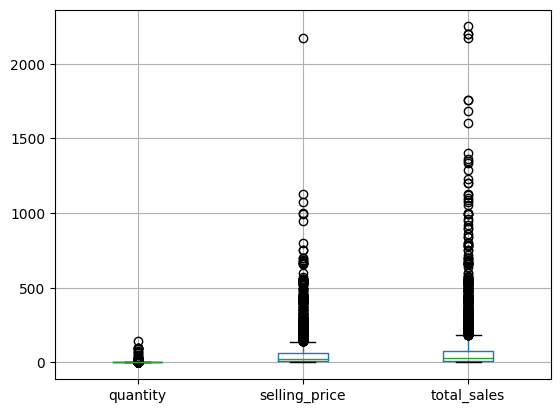

In [25]:
df3.boxplot(column=['quantity', 'selling_price', 'total_sales'])
plt.show()

terdapat outlier yang cukup banyak dan juga terdapat nilai outlier yang memiliki nilai yang sangat tinggi. Kita check variabel independen yaitu quantity dan selling_price

In [26]:
def handling_outlier(cols):
    
    Q1 = df3[cols].quantile(0.25)
    Q3 = df3[cols].quantile(0.75)
    IQR = Q3 - Q1
    df4 = df3[
        ~((df3[cols] < (Q1 - 1.5 * IQR)) | (df3[cols] > (Q3 + 1.5 * IQR)))
    ]
    return df4
    
df4 = handling_outlier('selling_price')
df4.head()

,index,product_name,brand_name,company,category_name,subcategory_name,bill_ID,quantity,selling_price,total_sales,address,latitude,longitude,town/city,country,bill_date
0,0,555,555,VIBHAVA MKTG,SCOURING PADS/SCRUBS,STEEL SCRUB,164,1.0,10.0,10.0,"524 Shoppes Blvd North Brunswick, NJ 08902 US",40.461454,-74.457146,North Brunswick,New Jersey,2020-01-03
1,1,2-IN-1 DAY & NIGHT,ENGAGE ON,I T C,"FRAGRANCE-PERFUM,DEO & COLOGNE",FRAGRANCE - DEODORANT,494,1.0,90.0,90.0,"15425 N Scottsdale Rd Ste 160 Scottsdale, AZ 8...",33.626296,-111.924820,Scottsdale,Arizona,2020-01-05
2,2,3M SCOTCH BRITE GENERAL PURPOS,SCOTCH BRITE,3M INDIA LTD,SCOURING PADS/SCRUBS,SCOURING PADS,31,1.0,9.5,9.5,"1601 Grand Ave Ste 100 Billings, MT 59102 US",45.784373,-108.556860,Billings,Montana,2020-01-01
3,2,3M SCOTCH BRITE GENERAL PURPOS,SCOTCH BRITE,3M INDIA LTD,SCOURING PADS/SCRUBS,SCOURING PADS,34,1.0,9.5,9.5,"10403 S 15th St Ste 106 Bellevue, NE 68123 US",41.157895,-95.934766,Bellevue,Nebraska,2020-01-01
4,2,3M SCOTCH BRITE GENERAL PURPOS,SCOTCH BRITE,3M INDIA LTD,SCOURING PADS/SCRUBS,SCOURING PADS,58,1.0,14.0,14.0,"3475 Las Vegas Blvd S Las Vegas, NV 89109 US",36.120091,-115.171758,Las Vegas,Nevada,2020-01-01


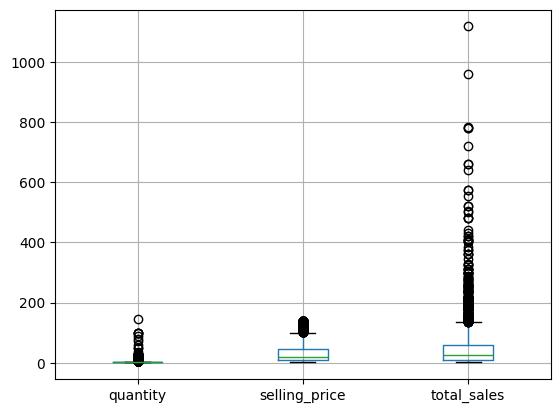

In [27]:
df4.boxplot(column=['quantity', 'selling_price', 'total_sales'])
plt.show()

Dari hasil imputasi terlihat bahwa sebagian besar outlier telah terhapus untuk variabel quantity dan selling_price

## 7. Exploratory Data Analysis & Visualization

### 1. Statistika Deskriptif

In [28]:
variabel_numerik = df4[['quantity','selling_price','total_sales']].describe()
variabel_kategorik = df4.describe(include='object')

# display
display_side_by_side([variabel_numerik, variabel_kategorik], ['Variabel Numerik', 'Variabel Kategorik'])


### 2. Shape & Info

In [29]:
df4.info()

print(f"\nDimensi Data = {df4.shape}")

<class 'pandas.core.frame.DataFrame'>
Index: 7701 entries, 0 to 8353
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             7701 non-null   int64         
 1   product_name      7701 non-null   object        
 2   brand_name        7701 non-null   object        
 3   company           7701 non-null   object        
 4   category_name     7701 non-null   object        
 5   subcategory_name  7701 non-null   object        
 6   bill_ID           7701 non-null   int64         
 7   quantity          7701 non-null   float64       
 8   selling_price     7701 non-null   float64       
 9   total_sales       7701 non-null   float64       
 10  address           7701 non-null   object        
 11  latitude          7701 non-null   float64       
 12  longitude         7701 non-null   float64       
 13  town/city         7701 non-null   object        
 14  country           7701 non-nu

### 3. Company dengan penjualan produk terbanyak?

In [30]:
df4_groupby_brand = df4.groupby(['company']).sum('total_sales')[['quantity', 'total_sales']].reset_index().sort_values('quantity', ascending=False)[:10]
df4_groupby_brand

,company,quantity,total_sales
90,HINDUSTAN UNILEVER LIMITED,2101.0,53241.04
29,BRITANNIA INDS,1956.0,25810.77
156,PARLE PRODS,1637.0,12844.79
140,MONDELEZ INTERNATIONAL,1469.0,17912.52
147,NESTLE INDIA,637.0,13075.62
92,I T C,563.0,7741.17
160,PEPSICO INDIA,423.0,5607.00
171,PROCTER & GAMBLE,322.0,10426.39
69,GODREJ CONSUMER PRODS,275.0,13044.48
187,S NARENDRA KUMAR,268.0,9755.04


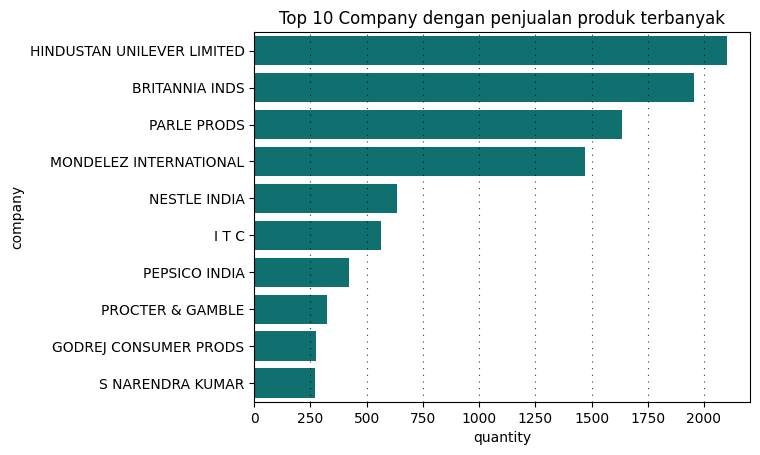

In [31]:
ax = sns.barplot(data=df4_groupby_brand, x='quantity', y='company', color='teal')
ax.set_title('Top 10 Company dengan penjualan produk terbanyak')
ax.grid(which='major', axis='x', linestyle=':', alpha=0.8, dashes=(1,5), color='blacK')


plt.show()

Artinya dengan hadir nya company tersebut di retail shop kita, dapat memberikan revenue stream yang besar karena besarnya transaksi yang diperoleh company tersebut. Selain itu, kita bisa menjalin hubungan business mutualisme dengan kita menyediakan platform penjualan dan mereka menyediakan barang untuk dijual di retail shop kita. Dengan itu kita bisa sustainable dan customer senang

### 4. Bagaiaman tren penjualan pada bulan januari?

In [32]:
df4_groupby_bills_company= df4.groupby(['bill_date']).sum('total_sales')[['quantity', 'total_sales']].reset_index().sort_values('bill_date', ascending=True)
df4_groupby_bills_company['growth_percentage'] = df4_groupby_bills_company.total_sales.pct_change().mul(100).round(2).map(lambda x: '{0:g}'.format(x) if x==x else x).fillna(0).astype(float)
df4_groupby_bills_company

,bill_date,quantity,total_sales,growth_percentage
0,2020-01-01,1397.0,39456.58,0.00
1,2020-01-02,1331.0,39982.71,1.33
2,2020-01-03,1425.0,38325.71,-4.14
3,2020-01-04,1836.0,53718.31,40.16
4,2020-01-05,1335.0,37488.39,-30.21
5,2020-01-06,459.0,8867.54,-76.35
6,2020-01-07,659.0,15740.48,77.51
7,2020-01-08,414.0,9740.30,-38.12
8,2020-01-09,335.0,6303.06,-35.29
9,2020-01-10,341.0,5593.11,-11.26


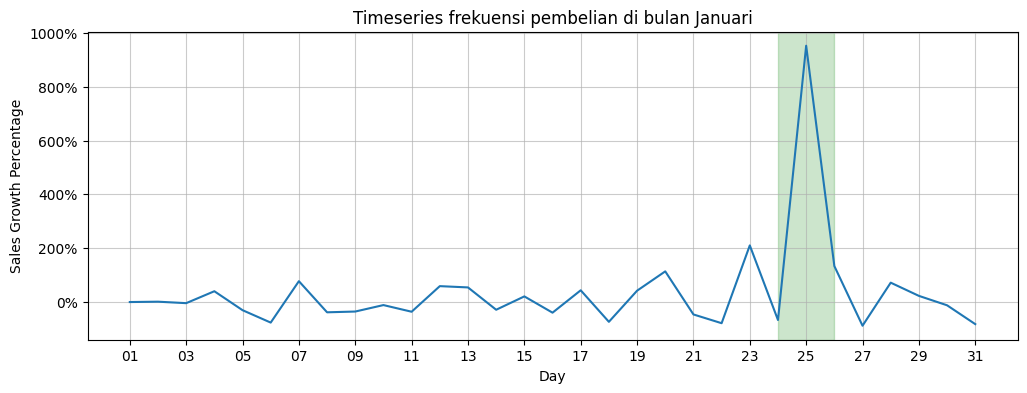

In [33]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax1 = sns.lineplot(data=df4_groupby_bills_company, x='bill_date', y='growth_percentage')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax1.set_yticklabels(ax1.get_yticks())
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

ax1.set_xlabel('Day')
ax1.set_ylabel('Sales Growth Percentage')
ax1.set_title('Timeseries frekuensi pembelian di bulan Januari')
ax1.grid(which='major', alpha=0.65)


plt.axvspan('2020-01-24', '2020-01-26', color='g', alpha=0.2)

plt.show()


Jika melihat chart diatas dapat di interpretasi bahwa pada hari ke 25 terjadi lonjakan penjualan yang sangat tinggi hingga naik 952.34% dari hari sebelumnya. Tentunya hari tersebut bertepatan dengan hari payday atau penggajian, orang-orang cenderung akan membelanjakan uang hasil jerih payah mereka untuk membeli produk yang di butuhkan atau di inginkan.

### 5. Produk apa yang memiliki sifat assosiasi yang tinggi?

In [34]:
market_basket = df4.groupby(['bill_ID', 'subcategory_name'])['quantity'].sum().unstack().fillna(0)
market_basket.head()

subcategory_name,AEROSOL,AFTER SHAVE LOTIONS,AGARBATTI,ALKALINE,ANTISEPTIC CREAMS,ANTISEPTIC LIQ,ASSORTED BISCUITS,ATTA,BAITS,BANANA CHIPS/LACHA/OTHERS,...,TRADITIONAL,TWIN BLADES-REFILLS,TWIN BLADES-SYSTEMS,VANASPATI CONS PACK (8/94),VANI CREAMS/SNOWS,VERMICILLI,WAFER CREAM,WASHING POWDERS/LIQUIDS,WAX POLISHES,WHITE POWDERS
bill_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
market_basket_encode = market_basket.applymap(encode_units)

market_basket_plus = market_basket_encode[(market_basket_encode > 0).sum(axis=1) >= 2] # filter bougt more than 1 item only
market_basket_plus.head()

subcategory_name,AEROSOL,AFTER SHAVE LOTIONS,AGARBATTI,ALKALINE,ANTISEPTIC CREAMS,ANTISEPTIC LIQ,ASSORTED BISCUITS,ATTA,BAITS,BANANA CHIPS/LACHA/OTHERS,...,TRADITIONAL,TWIN BLADES-REFILLS,TWIN BLADES-SYSTEMS,VANASPATI CONS PACK (8/94),VANI CREAMS/SNOWS,VERMICILLI,WAFER CREAM,WASHING POWDERS/LIQUIDS,WAX POLISHES,WHITE POWDERS
bill_ID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# apriori
frequent_itemsets_plus = apriori(market_basket_plus, min_support=0.03, use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)
frequent_itemsets_plus['length'] = frequent_itemsets_plus['itemsets'].apply(lambda x: len(x))

frequent_itemsets_plus

,support,itemsets,length
0,0.267361,(SWEET/COOKIES),1
1,0.252083,(CREAM),1
2,0.195833,(WASHING POWDERS/LIQUIDS),1
3,0.161111,(MAIN PACKS),1
4,0.156250,(MARIE),1
...,...,...,...
57,0.031944,"(TOOTH PASTES, CREAM)",2
58,0.031944,(SUGAR PANNED),1
59,0.031250,"(MOULDED, CREAM)",2
60,0.031250,"(WASHING POWDERS/LIQUIDS, BLENDED)",2


In [37]:
# association rules
association_rules(frequent_itemsets_plus, metric='lift', min_threshold=1).sort_values('lift', ascending=False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(WASHING POWDERS/LIQUIDS),(TOOTH PASTES),0.195833,0.097222,0.039583,0.202128,2.079027,0.020544,1.131481,0.645396
1,(TOOTH PASTES),(WASHING POWDERS/LIQUIDS),0.097222,0.195833,0.039583,0.407143,2.079027,0.020544,1.356426,0.574899
2,(WASHING POWDERS/LIQUIDS),(PREMIUM),0.195833,0.126389,0.048611,0.248227,1.963993,0.023860,1.162068,0.610363
3,(PREMIUM),(WASHING POWDERS/LIQUIDS),0.126389,0.195833,0.048611,0.384615,1.963993,0.023860,1.306771,0.561844
4,(TRADITIONAL),(WASHING POWDERS/LIQUIDS),0.098611,0.195833,0.036806,0.373239,1.905904,0.017494,1.283052,0.527313
5,(WASHING POWDERS/LIQUIDS),(TRADITIONAL),0.195833,0.098611,0.036806,0.187943,1.905904,0.017494,1.110007,0.591065
6,(SWEET/COOKIES),(SALT CRACKER),0.267361,0.084028,0.040278,0.150649,1.792852,0.017812,1.078438,0.603612
7,(SALT CRACKER),(SWEET/COOKIES),0.084028,0.267361,0.040278,0.479339,1.792852,0.017812,1.407132,0.482798
8,(NON-SALT CRACKER),(SWEET/COOKIES),0.118056,0.267361,0.050000,0.423529,1.584110,0.018437,1.270904,0.418088
9,(SWEET/COOKIES),(NON-SALT CRACKER),0.267361,0.118056,0.050000,0.187013,1.584110,0.018437,1.084820,0.503291


**semakin tinggi nilai lift, semakin tinggi asosiasi antar item. Jika nilai lift lebih dari 1, cukup untuk kita katakan bahwa kedua item tersebut saling terkait**. 
1. Dari hasil asosiasi rules diatas, WASHING POWDERS/LIQUIDS dan TOOTH PASTES adalah item yang memiliki tingkat asosiasi yang tinggi dilihat dari nilai **lift** pada table yang tinggi.Artinya jika seseorang membeli  WASHING POWDERS/LIQUIDS maka besar kemungkinan orang tersebut akan membeli TOOTH PASTES di satu transaksi yang sama begitupun sebaliknya
2. Selain itu, kita bisa melihat nilai **support** untuk WASHING POWDERS/LIQUIDS dan TOOTH PASTES sebesar 0.039583. Yang artinya 3.09% dari total transaksi adalah transaksi kedua item tersebut terjual pada satu transaksi yang sama

### 6.   Berdasarkan hasil analisis data, wilayah bagian US mana yang memiliki tingkat penjualan rendah? dan bagaimana strategi untuk meningkatkan penjualan di daerah tersebut?

Karena kita ingin melihat potensi penjualan pada tiap country dan karena data country sangatlah banyak maka kita bisa membagi country tersebut berdasarkan 3 wilayah menggunakan algoritma clustering

#### K-Means Clustering

In [38]:
X = df4[['latitude', 'longitude']]

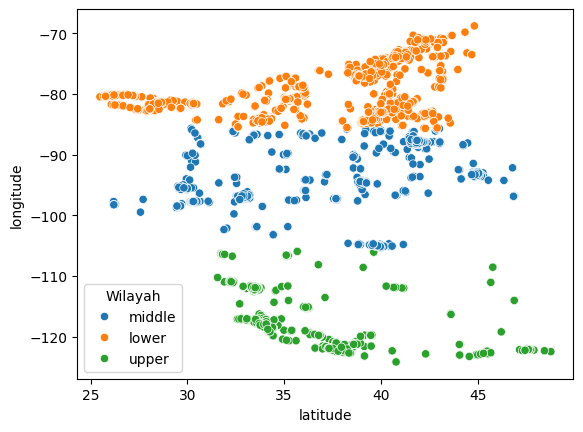

In [39]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

df4['Wilayah'] = X['Cluster']
df4['Wilayah'] = df4['Wilayah'].map({0:'middle', 1:'lower', 2:'upper'})

sns.scatterplot(data=df4, x='latitude', y='longitude', hue='Wilayah')
plt.show()

Dari chart diatas dapat di interpretasikan bahwa country dibagi menjadi tiga bagian
1. 0 = Middle
2. 1 = Lower
3. 2 = Upper

In [40]:
df4.groupby(['Wilayah', 'country'])['total_sales'].sum()

Wilayah  country      
middle   Alabama          7233.91
         Arizona             0.00
         Arkansas          947.35
         California          0.00
         Colorado         5107.00
                           ...   
upper    Washington       3668.50
         Washington DC       0.00
         West Virginia       0.00
         Wisconsin           0.00
         Wyoming             0.00
Name: total_sales, Length: 144, dtype: float64

#### Wilayah dengan pembeli terbanyak

In [41]:
df4_wilayah = df4.groupby('Wilayah')['total_sales'].sum().reset_index().sort_values('total_sales', ascending=False)
df4_wilayah

,Wilayah,total_sales
1,lower,197749.27
2,upper,89474.27
0,middle,62016.33


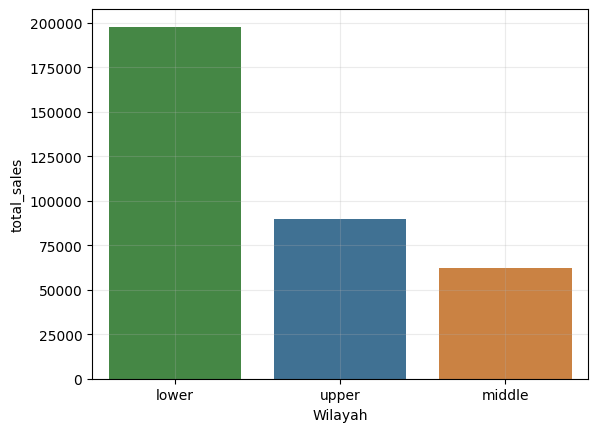

In [42]:
sns.barplot(data=df4_wilayah, x='Wilayah', y='total_sales', order=df4_wilayah.set_index('Wilayah').index, palette=['#3a923a', '#3274a1', '#e1812c'])
plt.grid(which='major',alpha=0.25)
plt.show()

Wilayah dengan penjualan terbanyak adalah wilayah Middle (Hijau) diikuti dengan wilayah Upper (Biru) dan Lower (Orange)

#### Kategori Produk yang terjual di tiga wilayah

In [43]:
df4_wilayah_top_category = df4.groupby(['category_name', 'Wilayah'])[['total_sales', 'quantity']].sum().reset_index()
df4_wilayah_top_category

,category_name,Wilayah,total_sales,quantity
0,AFTER SHAVE LOTIONS,middle,0.00,0.0
1,AFTER SHAVE LOTIONS,lower,235.00,2.0
2,AFTER SHAVE LOTIONS,upper,0.00,0.0
3,AGARBATTI & DHOOPBATTI,middle,584.50,14.0
4,AGARBATTI & DHOOPBATTI,lower,768.25,19.0
...,...,...,...,...
217,VERMICELLI & NOODLE,lower,5413.75,327.0
218,VERMICELLI & NOODLE,upper,2144.80,132.0
219,WASHING POWDERS/LIQUIDS,middle,3619.10,135.0
220,WASHING POWDERS/LIQUIDS,lower,14685.04,651.0


In [44]:
tiga_wilayah_category = df4_wilayah_top_category.query('quantity > 1').groupby('category_name')['Wilayah'].count().reset_index().query('Wilayah == 3')['category_name'].values
qry = " or ".join([f"category_name == '{x}'" for x in tiga_wilayah_category])

df4_tiga_wilayah_category = df4.query(qry)

In [45]:
# get sales groupby per category and wilayah
df4_tiga_wilayah_category_sales = df4_tiga_wilayah_category.groupby(['category_name', 'Wilayah'])[['total_sales']].sum().reset_index()
df4_tiga_wilayah_category_sales.head()

# get sales groupby by category 
df4_tiga_wilayah_category_sales_total = df4_tiga_wilayah_category.groupby(['category_name'])[['total_sales']].sum().reset_index()
df4_tiga_wilayah_category_sales_total.head()

# merge those two dataframe 
df4_tiga_wilayah_category_sales_merge = pd.merge(df4_tiga_wilayah_category_sales,df4_tiga_wilayah_category_sales_total, on='category_name', how='left')
print(df4_tiga_wilayah_category_sales_merge.shape)
df4_tiga_wilayah_category_sales_merge.head()

(156, 4)


,category_name,Wilayah,total_sales_x,total_sales_y
0,AGARBATTI & DHOOPBATTI,middle,584.50,1550.75
1,AGARBATTI & DHOOPBATTI,lower,768.25,1550.75
2,AGARBATTI & DHOOPBATTI,upper,198.00,1550.75
3,ALL AIR FRESHNERS(01/03),middle,607.50,2438.50
4,ALL AIR FRESHNERS(01/03),lower,1320.00,2438.50


In [46]:
# query category yang memiliki total sales > quantile(0.75) atau yang paling laku
df4_tiga_wilayah_category_sales_merge_quantile_75 = df4_tiga_wilayah_category_sales_merge.query(f'total_sales_y >= {df4_tiga_wilayah_category_sales_merge["total_sales_y"].quantile(0.75)}')
print(df4_tiga_wilayah_category_sales_merge_quantile_75.shape)
df4_tiga_wilayah_category_sales_merge_quantile_75.head()

(39, 4)


,category_name,Wilayah,total_sales_x,total_sales_y
18,BISCUITS - CORE & NON CORE,middle,9161.87,47702.86
19,BISCUITS - CORE & NON CORE,lower,25600.72,47702.86
20,BISCUITS - CORE & NON CORE,upper,12940.27,47702.86
27,CHEESE (4/94),middle,629.00,8185.00
28,CHEESE (4/94),lower,5979.00,8185.00


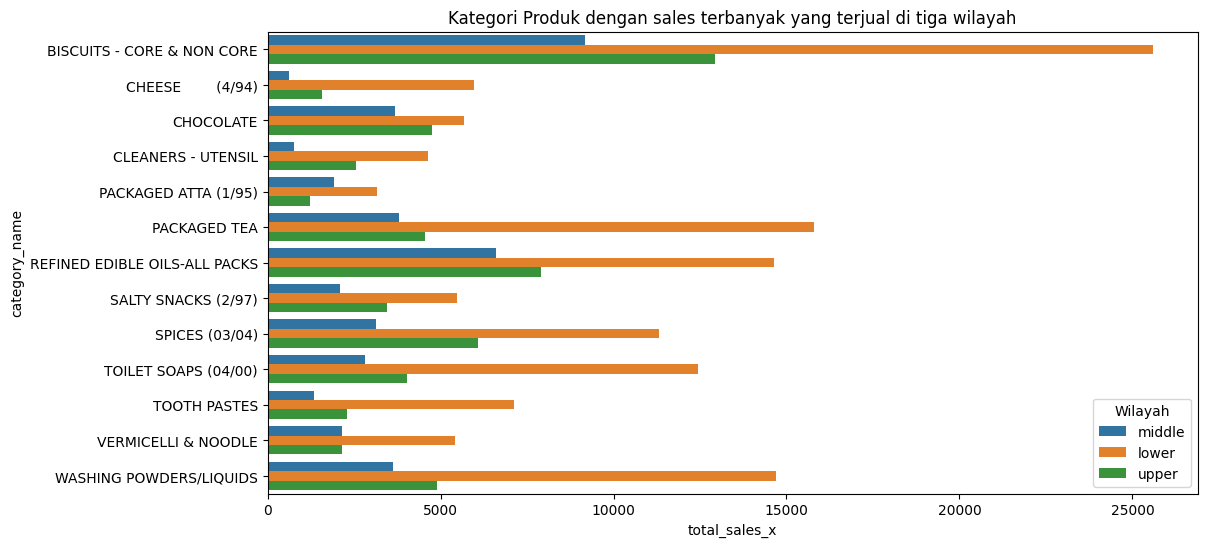

In [47]:
plt.figure(figsize=(12,6), dpi=100)
sns.barplot(data=df4_tiga_wilayah_category_sales_merge_quantile_75, x='total_sales_x', y='category_name', hue='Wilayah')
plt.title("Kategori Produk dengan sales terbanyak yang terjual di tiga wilayah")
plt.show()

1. Category Biscuits - Core & Non Core mendominasi penjualan retail dengan volume penjualan yang tinggi dan tersebar ke tiga wilayah diikuti dengan Refined Edible Oil Packs dan juga Spices
2. Meskipun Wilayah Middle (warna biru) cenderung mendominasi total penjualan, namun di kategori Chcocolate, penjualannya kalah dibanding dengan wilayah lain

#### Kategori Produk yang laku terjual di hanya salah satu atau dua wilayah

In [48]:
other_wilayah_category = df4_wilayah_top_category.query('quantity >= 1').groupby('category_name')['Wilayah'].count().reset_index().query('Wilayah <= 2')['category_name'].values
qry = " or ".join([f"category_name == '{x}'" for x in other_wilayah_category])

df4_other_wilayah_category = df4.query(qry)

In [49]:
df4_other_wilayah_category_sales = df4_other_wilayah_category.groupby(['category_name', 'Wilayah'])[['quantity','total_sales']].sum().reset_index()
print(df4_other_wilayah_category_sales.shape)
df4_other_wilayah_category_sales

(45, 4)


,category_name,Wilayah,quantity,total_sales
0,AFTER SHAVE LOTIONS,middle,0.0,0.0
1,AFTER SHAVE LOTIONS,lower,2.0,235.0
2,AFTER SHAVE LOTIONS,upper,0.0,0.0
3,ANTISEPTIC LIQUIDS (4/97),middle,0.0,0.0
4,ANTISEPTIC LIQUIDS (4/97),lower,5.0,355.0
5,ANTISEPTIC LIQUIDS (4/97),upper,1.0,50.0
6,CHYAVANPRASH,middle,1.0,84.0
7,CHYAVANPRASH,lower,0.0,0.0
8,CHYAVANPRASH,upper,0.0,0.0
9,CONDOMS,middle,0.0,0.0


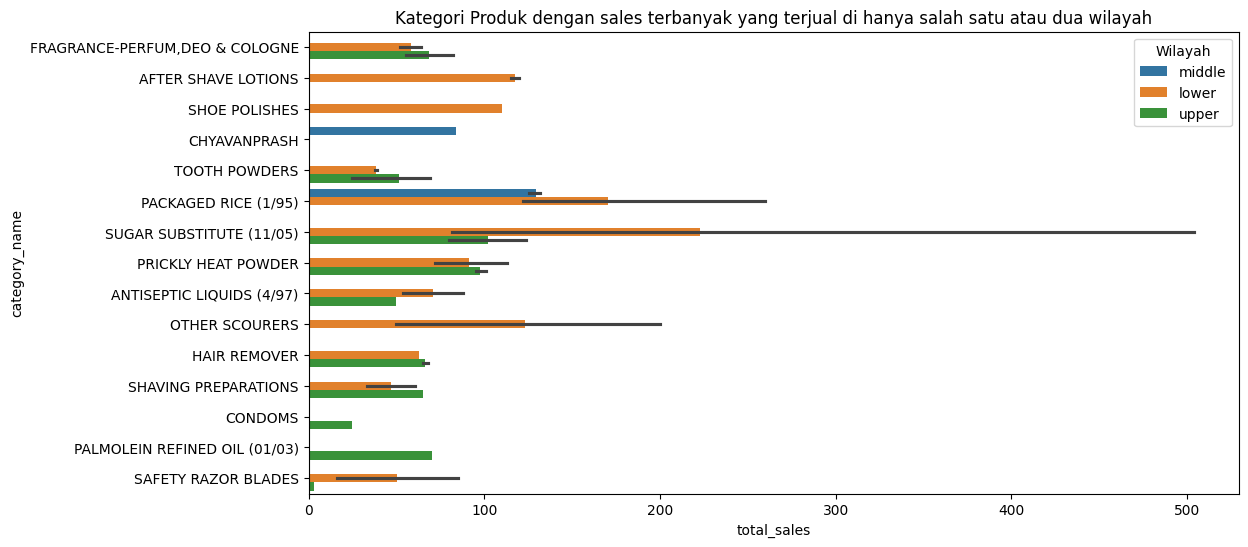

In [50]:
plt.figure(figsize=(12,6), dpi=100)
sns.barplot(data=df4_other_wilayah_category, x='total_sales', y='category_name', hue='Wilayah')
plt.title('Kategori Produk dengan sales terbanyak yang terjual di hanya salah satu atau dua wilayah')
plt.show()

1. Dari chart kita bisa lihat kategori produk Sugar Subtitute, Hair Remover, Shaving Prep, Tooth Powders cenderung dibeli dari pelanggan wilayah Lower dan Middle
2. Sedangkan, kategori produk Packaged Rice cenderung dibeli oleh pelanggan dari wilayah Middle dan Upper
3. Lalu, After Shave Lotions, Shoe Polishes, dan Other Scourers cenderung dibeli oleh pelanggan dari wilayah Middle
4. Dan kategori produk Chyavanprash cenderung dibeli oleh pelanggan dri wilayah Upper

## 8. Rekomendasi

1.   Hindustian Unilever Limited, Britannia Inds, Parle Prods, dan Modelez International merupakan company yang memiliki total penjualan terbesar. Rekomendasi yang dapat diberikan adalah dengan menjalin hubungan kerja sama kepada company tersebut. Contoh nya bisa dengan membuat kerja sama meluncurkan produk ekslusif yang hanya di jual di platform retail online kita, dengan itu kita bisa mendatangkan pelanggan baru dan meningkatkan revenue stream
2.   Terjadi kenaikan penjualan pada hari gaji atau payday, sehingga rekomendasi yang dapat diberikan adalah menekankan promosi pada hari tersebut agar penjualan naik dan mendatangkan pelanggan baru yang ingin membelanjakan uang gaji mereka 
3.   Dari hasil asosiaction rule, terdapat beberapa item yang berpotensi terjual dalam satu transaksi secara berbarengan seperti WASHING POWDERS/LIQUIDS dan TOOTH PASTES. Rekomendasi yang dapat diberikan adalah kita bisa menaruh kedua barang tersebut secara berdekatan, lalu bisa juga menjual nya dengan cara bundling selain itu kita juga dapat memberikan discount untuk kedua item tersebut bila beli kedua barang tersebut
4. Wilayah Lower paling sedikit berkontribusi terhadap total penjualan. Rekomendasi yang bisa diberikan adalah dengan menyajikan barang diskon untuk boost penjualan di daerah tersebut
5. Berdasarkan penjualan kategori produk berdasarkan wilayah, rekomendasi yang bisa diberikan adalah dari data tersebut kita bisa mengembangkan product recommendation system berdasarkan wilayah. Seperti kita boost penjualan Sugar Substitute, Hair Remover, Shaving Preparation, dan Tooth Powders untuk wilayah Middle dan Lower

## 9. Kesimpulan - Create the story

1.   Isi disini
2.   Isi disini
3.   Isi disini